
# Shared rides with pricing - Delft 

 ### Choice Function (Deterministic):
 `pool_price.py`
 * Pickup Distance: distance from driver initial position to the first pickup point
 * Travel Distance: distance from driver's initial position to the drop off point of the last passenger
 * Operating Cost: This include all the expenses
 * Profit: Driver revenue to serve the request
            
 
  ### KPI:
   
   * Profit of Individual driver
   * Profit of all the drivers
   * No.of rejected rides
   * U - PAX (Utility) 
  
   ### TBD- Choice Function (Probablistic):
  
  * choice logic to be applied inside `pool_price.py` 
  * P(R)= exp(beta * Profit_R)/ sum_all the rides( exp(beta * Profit_R)
 



In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging
import matplotlib.pyplot as plt

import pandas as pd
import ExMAS


## Pricing for Delft, Netherlands

In [3]:
params = get_config('../../data/config/delft.json')  # load configuration

params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 0.1 # 6 minutes hour of simulation
params.nP = 10 # reuqests (and passengers)
params.nV = 10 # vehicles

## Parameters for ExMAS

In [4]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.5
params.shareability.comm_rate = 0.2

inData = load_G(inData, params)  # load network graph 

inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 


08-02-23 12:07:09-INFO-Initializing pairwise trip shareability between 10 and 10 trips.
08-02-23 12:07:09-INFO-creating combinations
08-02-23 12:07:09-INFO-90	 nR*(nR-1)
08-02-23 12:07:10-INFO-Reduction of feasible pairs by 91.11%
08-02-23 12:07:10-INFO-Degree 2 	Completed
08-02-23 12:07:10-INFO-trips to extend at degree 2 : 20
08-02-23 12:07:10-INFO-At degree 2 feasible extensions found out of 3 searched
08-02-23 12:07:10-INFO-Degree 3 	Completed
08-02-23 12:07:10-INFO-trips to extend at degree 3 : 3
08-02-23 12:07:10-INFO-At degree 3 feasible extensions found out of 0 searched
08-02-23 12:07:10-INFO-Degree 4 	Completed
08-02-23 12:07:10-INFO-Max degree reached 4
08-02-23 12:07:10-INFO-Trips still possible to extend at degree 4 : 0


In [5]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

08-02-23 12:07:10-INFO-Matching 10 trips to 33 rides in order to min u_pax
08-02-23 12:07:10-INFO-Problem solution: Optimal. 
Total costs for single trips:             60 
reduced by matching to:                   54


In [6]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],9.794000,529,1,[9.794],"[0, 529]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1448535730, 44872846]","[None, 0, 0]",node time req_id od 0 ...,529,5.29,7.94250,1.58850,6.35400
1,[1],5.986000,323,1,[5.986000000000001],"[1, 323]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 6248301255, 1620840079]","[None, 1, 1]",node time req_id od 0 ...,323,3.23,4.85550,0.97110,3.88440
2,[2],5.391000,291,1,[5.391],"[87, 291]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44883810, 44808574]","[None, 2, 2]",node time req_id od 0 NaN...,291,2.91,4.37250,0.87450,3.49800
3,[3],6.063000,327,1,[6.063],"[167, 327]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44786364, 1668136718]","[None, 3, 3]",node time req_id od 0 ...,327,3.27,4.91850,0.98370,3.93480
4,[4],1.891500,102,1,[1.8915],"[197, 102]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1436427141, 44830130]","[None, 4, 4]",node time req_id od 0 ...,102,1.02,1.53450,0.30690,1.22760
5,[5],9.196000,497,1,[9.196],"[246, 497]",[5],[5],1,5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0,"[None, 44723646, 1851699236]","[None, 5, 5]",node time req_id od 0 ...,497,4.97,7.45650,1.49130,5.96520
6,[6],5.477500,296,1,[5.477499999999999],"[251, 296]",[6],[6],1,6,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,"[None, 1615493865, 44767578]","[None, 6, 6]",node time req_id od 0 ...,296,2.96,4.44150,0.88830,3.55320
7,[7],5.534500,299,1,[5.5345],"[265, 299]",[7],[7],1,7,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0,"[None, 44835261, 1575265302]","[None, 7, 7]",node time req_id od 0 ...,299,2.99,4.48800,0.89760,3.59040
8,[8],6.570500,355,1,[6.5705],"[284, 355]",[8],[8],1,8,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,"[None, 44883814, 839335227]","[None, 8, 8]",node time req_id od 0 N...,355,3.55,5.32800,1.06560,4.26240
9,[9],4.245500,229,1,[4.2455],"[316, 229]",[9],[9],1,9,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44772088, 44811247]","[None, 9, 9]",node time req_id od 0 NaN...,229,2.29,3.44400,0.68880,2.75520


## Simulation with MaaSSim 

08-02-23 12:07:51-INFO-Matching 10 trips to 33 rides in order to min u_pax
08-02-23 12:07:51-INFO-Problem solution: Optimal. 
Total costs for single trips:             60 
reduced by matching to:                   54
08-02-23 12:07:51-WARNING-Setting up 0.1h simulation at 2023-02-08 12:04:17 for 10 vehicles and 10 passengers in Delft, Netherlands
08-02-23 12:07:52-CRITICAL-this is request 0 with [0, 10, 11, 12, 22, 23] available rides.
08-02-23 12:07:52-CRITICAL-ride 0 available [1]
08-02-23 12:07:52-CRITICAL-ride 10 available [1, 0]
08-02-23 12:07:52-CRITICAL-ride 11 available [1, 0]
08-02-23 12:07:52-CRITICAL-ride 12 available [1, 0]
08-02-23 12:07:52-CRITICAL-ride 22 available [1, 0]
08-02-23 12:07:52-CRITICAL-ride 23 available [1, 0]
08-02-23 12:07:52-CRITICAL-this is reuqest 0 with [0, 10, 11, 12, 22, 23] still available rides.
08-02-23 12:07:52-CRITICAL-vehicle 1 has 6 choices
08-02-23 12:07:52-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 10 of degree 2, with trav

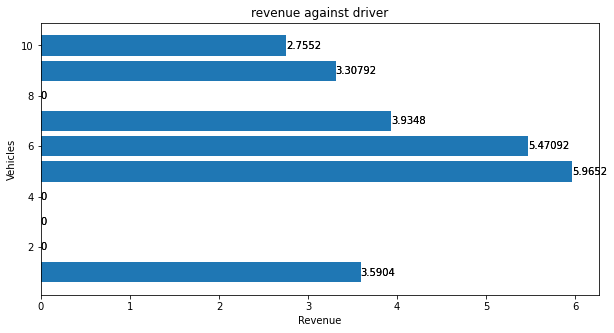

In [7]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

In [8]:
sim.res[0].pax_exp


,ACCEPTS_OFFER,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,MEETS_DRIVER_AT_PICKUP,RECEIVES_OFFER,REQUESTS_RIDE,SETS_OFF_FOR_DEST,STARTS_DAY,IS_REJECTED_BY_VEHICLE,REJECTS_OFFER,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE,TRAVEL,WAIT,OPERATIONS
pax,,,,,,,,,,,,,,,,,
0,15.0,559.0,20.0,30.0,335.0,230.0,0.0,10.0,0,0,0,0,0,0,559.0,565.0,55.0
1,15.0,354.0,20.0,30.0,24.0,156.0,1.0,10.0,0,0,0,0,0,0,354.0,180.0,55.0
2,15.0,396.0,20.0,30.0,42.0,3.0,87.0,10.0,0,0,0,0,0,0,396.0,45.0,55.0
3,15.0,327.0,20.0,30.0,101.0,0.0,167.0,10.0,0,0,0,0,0,0,327.0,101.0,55.0
4,15.0,102.0,35.0,30.0,142.0,87.0,95.0,10.0,0,0,0,0,0,0,102.0,229.0,55.0
5,15.0,553.0,35.0,30.0,0.0,1.0,230.0,10.0,0,0,0,0,0,0,553.0,1.0,55.0
6,15.0,322.0,2.0,30.0,353.0,18.0,251.0,10.0,0,0,0,0,0,0,322.0,371.0,55.0
7,15.0,318.0,35.0,30.0,709.0,0.0,250.0,10.0,0,0,0,0,0,0,318.0,709.0,55.0
8,15.0,404.0,35.0,30.0,142.0,251.0,18.0,10.0,0,0,0,0,0,0,404.0,393.0,55.0


In [15]:
sim.res[0].all_kpi # All driver revenue 

25.02444

In [9]:
sim.res[0].veh_exp['REVENUE'].to_list()

[3.5904,
 0.0,
 0.0,
 0.0,
 5.9652,
 5.4709200000000004,
 3.9348,
 0.0,
 3.30792,
 2.7552]

In [10]:

list(sim.vehs.keys())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
sim.res[0].all_kpi

25.02444

In [14]:
sim.res[0].veh_exp

,nRIDES,nREJECTED,OUT,STARTS_DAY,OPENS_APP,RECEIVES_REQUEST,ACCEPTS_REQUEST,REJECTS_REQUEST,IS_ACCEPTED_BY_TRAVELLER,IS_REJECTED_BY_TRAVELLER,...,REPOSITIONED,DECIDES_NOT_TO_DRIVE,ENDS_SHIFT,TRAVEL,WAIT,CRUISE,OPERATIONS,IDLE,PAX_KM,REVENUE
veh,,,,,,,,,,,,,,,,,,,,,
1,2.0,0.0,False,0,0,0.0,15.0,0,285.0,0,...,0,0,6202.0,318.0,0,679.0,360.0,4845.0,8.287,3.59040
2,0.0,0.0,False,0,0,246.0,0.0,0,0.0,0,...,0,0,7313.0,0.0,0,0.0,0.0,7313.0,0.000,0.00000
3,0.0,0.0,False,0,0,0.0,0.0,0,0.0,0,...,0,0,7559.0,0.0,0,0.0,0.0,7559.0,0.000,0.00000
4,0.0,0.0,False,0,0,0.0,0.0,0,0.0,0,...,0,0,7559.0,0.0,0,0.0,0.0,7559.0,0.000,0.00000
5,2.0,0.0,False,0,0,1.0,15.0,0,115.0,0,...,0,0,6695.0,553.0,0,120.0,190.0,5832.0,8.208,5.96520
6,2.0,0.0,False,0,0,251.0,15.0,0,53.0,0,...,0,0,6568.0,322.0,0,290.0,128.0,5828.0,6.513,5.47092
7,1.0,0.0,False,0,0,167.0,15.0,0,20.0,0,...,0,0,6899.0,327.0,0,101.0,65.0,6406.0,3.279,3.93480
8,0.0,0.0,False,0,0,284.0,0.0,0,0.0,0,...,0,0,7275.0,0.0,0,0.0,0.0,7275.0,0.000,0.00000
9,2.0,0.0,False,0,0,87.0,15.0,0,58.0,0,...,0,0,6966.0,189.0,0,184.0,133.0,6460.0,3.938,3.30792


## Plotting Graph of driver vs revenue

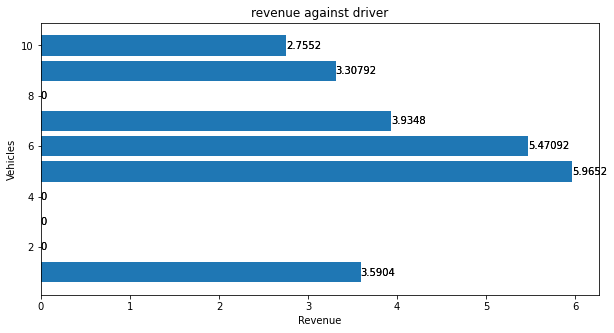

In [12]:
# plot graph of driver revenue
vehicles  = list(sim.res[0].veh_exp.index.to_list())
revenues = sim.res[0].veh_exp['REVENUE'].to_list()
fig, ax = plt.subplots(figsize = (10,5))
bars = ax.barh(vehicles, revenues)
ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)


plt.xlabel("Revenue")
plt.ylabel("Vehicles")
plt.title("revenue against driver")
plt.show()